## Training a Random Forests Model

In [4]:
import os

from qsprpred.models import SklearnModel
from qsprpred.data import QSPRDataset
from qsprpred.models import OptunaOptimization
from qsprpred.models import CrossValAssessor
from sklearn.ensemble import RandomForestClassifier
from qsprpred.data import RandomSplit, BootstrapSplit
from qsprpred.data.descriptors.fingerprints import MorganFP


os.makedirs("../output/models", exist_ok=True)

# Read receptor name from the text file
with open("../output/data/receptor.txt", "r") as file:
    receptor = file.read().strip()

dataset = QSPRDataset.fromTableFile(
    filename=f"../output/data/{receptor}_Dataset.tsv",
    store_dir="../output/data",
    name=f"Splitting{receptor}Dataset",
    target_props=[{"name": "pchembl_value_Mean", "task": "SINGLECLASS", "th": [6.5]}],
    random_state=42
)

dataset.addDescriptors([MorganFP(radius=3, nBits=2048)])
dataset.getDescriptors().shape

def print_split(ds):
    train, test = ds.getFeatures()
    print(train.shape)
    print(test.shape)
    print(test.index)


print_split(dataset)

(12440, 2048)
(0, 2048)
Index([], dtype='object', name='QSPRID')


In [5]:
model = SklearnModel( #test with new model types
    base_dir="../output/models/",
    alg=RandomForestClassifier,
    name="Splitting{receptor}Model",
    random_state=dataset.randomState
)
search_space_bs = {"n_estimators": ["int", 10, 100, 250]}
optimizer = OptunaOptimization(
    param_grid=search_space_bs,
    n_trials=5,  
    model_assessor=CrossValAssessor(
        scoring="roc_auc",
        split=BootstrapSplit(split=RandomSplit(0.2), n_bootstraps=5)
    )
)
optimizer.optimize(model, dataset)

qsprpred - WARNING - Explicitly specified random state (42)will override model settings read from file: 42.
[I 2025-03-13 16:43:48,926] A new study created in memory with name: no-name-5d673c6b-4202-4747-a051-1743b54beb39
[I 2025-03-13 16:45:55,254] Trial 0 finished with value: 0.6071787101052477 and parameters: {'n_estimators': 44}. Best is trial 0 with value: 0.6071787101052477.
[I 2025-03-13 16:49:48,195] Trial 1 finished with value: 0.606283259771417 and parameters: {'n_estimators': 96}. Best is trial 0 with value: 0.6071787101052477.
[I 2025-03-13 16:52:32,718] Trial 2 finished with value: 0.6066767248200836 and parameters: {'n_estimators': 76}. Best is trial 0 with value: 0.6071787101052477.
[I 2025-03-13 16:54:51,227] Trial 3 finished with value: 0.6070033691236117 and parameters: {'n_estimators': 64}. Best is trial 0 with value: 0.6071787101052477.
[I 2025-03-13 16:55:44,046] Trial 4 finished with value: 0.6086201837335177 and parameters: {'n_estimators': 24}. Best is trial 4 w

{'n_estimators': 24}

### Bootstrapping with optimized model

In [6]:
# run bootstrapping ten times with the optimized model
CrossValAssessor(
    scoring="roc_auc",
    split=BootstrapSplit(split=RandomSplit(0.2), n_bootstraps=10)
)(model, dataset)

array([0.58546394, 0.62751075, 0.60950626, 0.60048516, 0.62013481,
       0.59128381, 0.60499049, 0.61562164, 0.60755865, 0.60703854])

In [7]:
# evaluate on the test set as well
from qsprpred.models import TestSetAssessor

TestSetAssessor(scoring="roc_auc")(model, dataset)

ValueError: Found array with 0 sample(s) (shape=(0, 2048)) while a minimum of 1 is required by ExtraTreesClassifier.

In [8]:
_ = model.save()

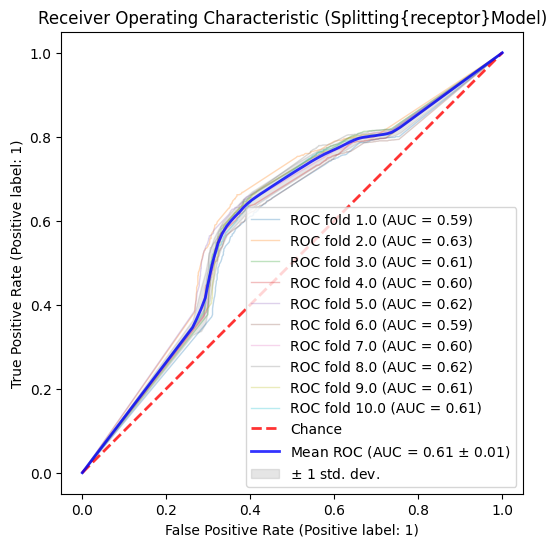

[<Figure size 600x600 with 1 Axes>]

<Figure size 640x480 with 0 Axes>

In [9]:
# plot the results for bootstrapping
from qsprpred.plotting.classification import ROCPlot

plot = ROCPlot([model])
plot.make(save=True, show=True, property_name=model.targetProperties[0].name,
          validation="cv")

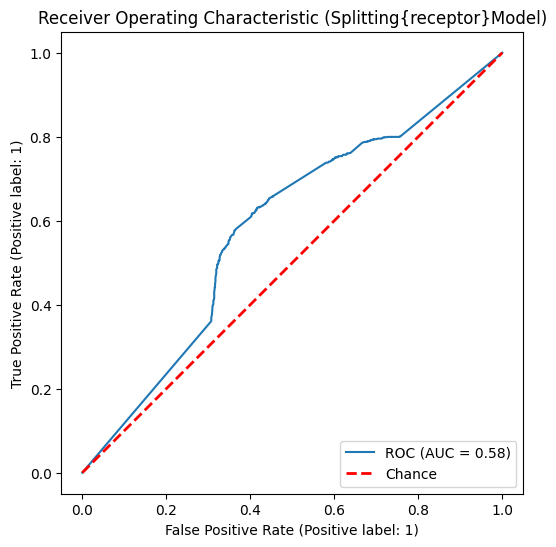

[<Figure size 600x600 with 1 Axes>]

<Figure size 640x480 with 0 Axes>

In [10]:
# plot test set results
plot.make(save=True, show=True, property_name=model.targetProperties[0].name,
          validation="ind")

## Cross validation using ScaffoldSplit

In [11]:
from qsprpred.data import ScaffoldSplit
from qsprpred.models import SklearnModel
from qsprpred.models import CrossValAssessor

CrossValAssessor(
    scoring="roc_auc",
    split=ScaffoldSplit(n_folds=10, scaffold=BemisMurckoRDKit())
)(model, dataset)

NameError: name 'BemisMurckoRDKit' is not defined

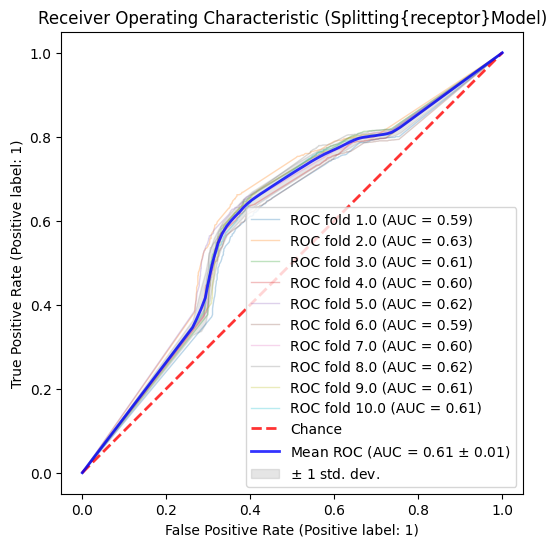

[<Figure size 600x600 with 1 Axes>]

<Figure size 640x480 with 0 Axes>

In [12]:
plot.make(save=True, show=True, property_name=model.targetProperties[0].name,
          validation="cv")

## Cross validation using Temporal split

<Axes: >

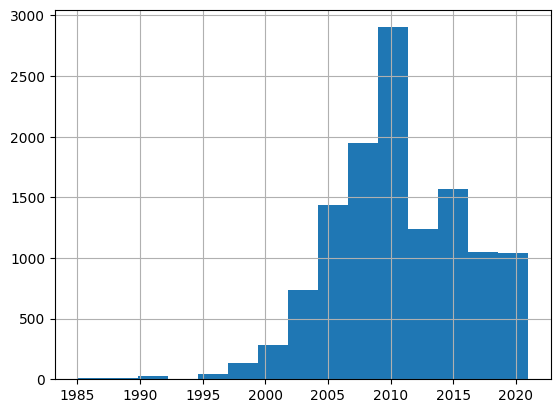

In [13]:
dataset.getProperty("Year").hist(bins=15)

In [14]:
from qsprpred.data import TemporalSplit

CrossValAssessor(
    scoring="roc_auc",
    split=TemporalSplit(timesplit=[2000, 2010, 2020], timeprop="Year")
)(model, dataset)

array([0.5490334 , 0.57708055, 0.59973659])

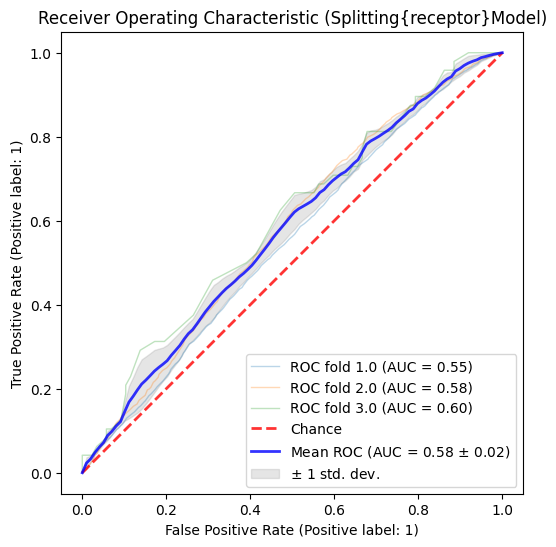

[<Figure size 600x600 with 1 Axes>]

<Figure size 640x480 with 0 Axes>

In [15]:
plot.make(save=True, show=True, property_name=model.targetProperties[0].name,
          validation="cv")

These splits are not saved to the dataset, but the assessments and optimizations can be reproduced by setting the random state to the same value. You can also explicitly save the splits to by adding a monitor to the `ModelAssessor` or `HyperparameterOptimizer`, see the [monitoring tutorial](../../advanced/modelling/monitoring.ipynb) for more information.

### Making predictions

In [16]:
smiles_list = ["c1(cc(c(O)cc1)O)CCN", "CC(=O)OC1=CC=CC=C1C(=O)O",
               "CC(C)CC1=CC=C(C=C1)C(C)C(=O)O"]

model.predictMols(smiles_list)

NotFittedError: This ExtraTreesClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

### Reloading

In [ ]:
dataset = QSPRDataset.fromFile(
    "./output/data/{receptor}_Dataset/{receptor}Dataset_meta.json")
model = SklearnModel.fromFile(
    "./output/models/{receptor}_Model/QuickStartModel_meta.json")
# or
dataset = QSPRDataset(
    name="{receptor}_Dataset",
    store_dir="./data/",
)
model = SklearnModel(
    name="{receptor}Model",
    base_dir="./output/models/"
)